In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Necessary Importations

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import missingno as msno

from nltk.corpus import stopwords
import nltk
import re

import json

import spacy
from spacy.tokens import Doc, Span
from spacy import displacy

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight


import tensorflow as tf

from transformers import TFBertForTokenClassification, AutoConfig

# Loading Dataset : NER darija.csv

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/datasets/NER darija.csv", sep=",")

# Dataset Description:

The dataset is a Named Entity Recognition (NER) dataset in Darija, a variant of Arabic language. It consists of 65,903 tokens, which are individual units of text such as words or characters. The dataset includes 9 categories for labeling the named entities found in the text. The categories and their descriptions are as follows:

**B-LOC** (*Beginning of a location entity*): Marks the beginning of a location entity.

**I-LOC** (*Inside a location entity*): Indicates that the token is inside a location entity.

**O** (*Token outside any named entity*): Indicates that the token is not part of any named entity.

**B-ORG** (*Beginning of an organization entity*): Denotes the beginning of an organization entity.

**I-ORG** (*Inside an organization entity*): Indicates that the token is inside an organization entity.

**B-MISC** (Beginning of a miscellaneous entity): Represents the beginning of a miscellaneous entity.

**I-MISC** (Inside a miscellaneous entity): Specifies that the token is inside a miscellaneous entity.

**B-PER** (Beginning of a person entity): Marks the beginning of a person entity.

**I-PER** (Inside a person entity): Denotes that the token is inside a person entity.

# Visualizing Dataset

In [ ]:
df

,Sentence,Token,Tag
0,0,Uppsala,B-LOC
1,0,),O
2,0,هيّا,O
3,0,رابع,O
4,0,أكبر,O
...,...,...,...
65899,2510,فرقة,O
65900,2510,ديال,O
65901,2510,لكورة,O
65902,2510,ديال,O


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65904 entries, 0 to 65903
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  65904 non-null  int64 
 1   Token     65897 non-null  object
 2   Tag       65904 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


# Handeling missing Values

In [ ]:
df.isna().sum()

Sentence    0
Token       7
Tag         0
dtype: int64

In [ ]:
df = df.dropna()

In [ ]:
df.isna().sum()

Sentence    0
Token       0
Tag         0
dtype: int64

# Entities description

In [ ]:
#Extracting unique tags
pd.unique(df['Tag']).tolist()

['B-LOC', 'O', 'B-ORG', 'B-MISC', 'I-ORG', 'I-MISC', 'I-LOC', 'B-PER', 'I-PER']

- B-LOC: Beginning of a location entity
- O: Token outside any named entity
- B-ORG: Beginning of an organization entity
- B-MISC: Beginning of a miscellaneous entity
- I-ORG: Inside an organization entity
- I-MISC: Inside a miscellaneous entity
- I-LOC: Inside a location entity
- B-PER: Beginning of a person entity
- I-PER: Inside a person entity

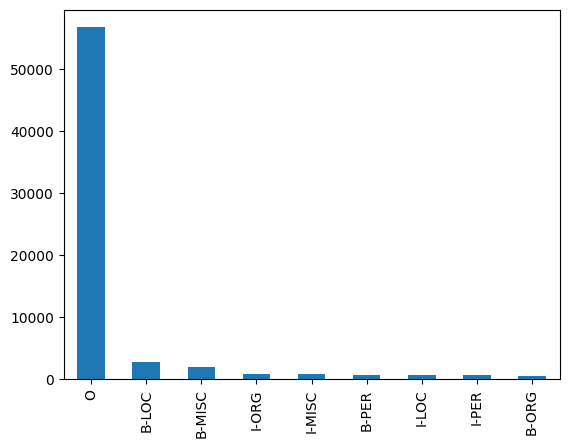

In [ ]:
df['Tag'].value_counts().plot(kind='bar')
plt.show()

# Visualizing Named Entities

In [ ]:
# Create a blank spaCy nlp pipeline
nlp = spacy.blank("ar")

# Create a Doc Doc object
doc = Doc(nlp.vocab, words=df['Token'].astype(str).tolist(), ents=df['Tag'])

In [ ]:
displacy.render(doc, style="ent",jupyter=True)

# Create Model

In [ ]:
df

,Sentence,Token,Tag
0,0,Uppsala,B-LOC
1,0,),O
2,0,هيّا,O
3,0,رابع,O
4,0,أكبر,O
...,...,...,...
65899,2510,فرقة,O
65900,2510,ديال,O
65901,2510,لكورة,O
65902,2510,ديال,O


In [ ]:
labels = np.array(['O', 'B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER'])
label_mapping = {label: index for index, label in enumerate(labels)}

df['Tag'] = df['Tag'].apply(lambda x: label_mapping[x])

<ipython-input-48-96e26f0433c1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tag'] = df['Tag'].apply(lambda x: label_mapping[x])


In [ ]:
num_class = len(labels)
print(f'Nuber of Classes = {num_class}')

Nuber of Classes = 10


In [ ]:
df

,Sentence,Token,Tag
0,0,Uppsala,2
1,0,),1
2,0,هيّا,1
3,0,رابع,1
4,0,أكبر,1
...,...,...,...
65899,2510,فرقة,1
65900,2510,ديال,1
65901,2510,لكورة,1
65902,2510,ديال,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65897 entries, 0 to 65903
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  65897 non-null  int64 
 1   Token     65897 non-null  object
 2   Tag       65897 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.0+ MB


In [ ]:
max_length = df.groupby('Sentence').count()['Token'].max()
print(f'Max Lenght = {max_length}')

Max Lenght = 205


In [ ]:
num_sentence = len(pd.unique(df['Sentence']))
print(f'Number of Sentence = {num_sentence}')

Number of Sentence = 2511


In [ ]:
tokens = df.groupby('Sentence')['Token'].agg(lambda x: x.tolist())

tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(tokens)

X = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(tokens), maxlen = max_length, padding='post', truncating='post')

In [ ]:
tokenizer_json = tokenizer.to_json()

with open("tokenizer.json", "w") as file:
    file.write(tokenizer_json)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
print(f'Vocabulary Size = {vocab_size}')

Vocabulary Size = 14165


In [ ]:
Tags = df.groupby('Sentence')['Tag'].agg(lambda x: x.tolist())

y = tf.keras.preprocessing.sequence.pad_sequences(Tags, maxlen = max_length, padding='post', truncating='post')

In [ ]:
print(f'Input Shape: {X.shape}')
print(f'Output Shape: {y.shape}')

Input Shape: (2511, 205)
Output Shape: (2511, 205)


In [ ]:
token_type_ids = np.array([[i]*X.shape[1] for i in range(X.shape[0])])

In [ ]:
tokenType_train, tokenType_test, label_train, _ = train_test_split(token_type_ids, y, test_size=0.2)
tokenType_train, tokenType_val, _, _ = train_test_split(tokenType_train, label_train, test_size=0.2)

inputIds_train, inputIds_test, label_train, label_test = train_test_split(X, y, test_size=0.2)
inputIds_train, inputIds_val, label_train, label_val = train_test_split(inputIds_train, label_train, test_size=0.2)

In [ ]:
mask_train = (inputIds_train != 0).astype(int)
mask_val = (inputIds_val != 0).astype(int)
mask_test = (inputIds_test != 0).astype(int)

In [ ]:
print(f'train Input Ids Shape: {inputIds_train.shape}')
print(f'train Token Type Ids Shape: {tokenType_train.shape}')
print(f'train Attention Mask Shape: {mask_train.shape}')
print(f'train Output Shape: {label_train.shape}')
print()
print(f'val Input Ids Shape: {inputIds_val.shape}')
print(f'val Token Type Ids Shape: {tokenType_val.shape}')
print(f'val Attention Mask Shape: {mask_val.shape}')
print(f'val Output Shape: {label_val.shape}')
print()
print(f'test Input Ids Shape: {inputIds_test.shape}')
print(f'test Token Type Ids Shape: {tokenType_test.shape}')
print(f'test Attention Mask Shape: {mask_test.shape}')
print(f'test Output Shape: {label_test.shape}')

train Input Ids Shape: (1606, 205)
train Token Type Ids Shape: (1606, 205)
train Attention Mask Shape: (1606, 205)
train Output Shape: (1606, 205)

val Input Ids Shape: (402, 205)
val Token Type Ids Shape: (402, 205)
val Attention Mask Shape: (402, 205)
val Output Shape: (402, 205)

test Input Ids Shape: (503, 205)
test Token Type Ids Shape: (503, 205)
test Attention Mask Shape: (503, 205)
test Output Shape: (503, 205)


In [ ]:
def map_example_to_dict(input_ids, attention_masks, label):
  return {
      "input_ids": input_ids,
      "attention_mask": attention_masks,
  }, label

In [ ]:
ds_train_encoded = tf.data.Dataset.from_tensor_slices((inputIds_train, mask_train, label_train)).map(map_example_to_dict).batch(16)
ds_val_encoded = tf.data.Dataset.from_tensor_slices((inputIds_val, mask_val, label_val)).map(map_example_to_dict).batch(16)
ds_test_encoded = tf.data.Dataset.from_tensor_slices((inputIds_test, mask_test, label_test)).map(map_example_to_dict).batch(16)

In [ ]:
learning_rate = 1e-4

number_of_epochs = 20

model = TFBertForTokenClassification.from_pretrained('UBC-NLP/MARBERTv2', num_labels=num_class)

config.json:   0%|          | 0.00/757 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/652M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForTokenClassification.

Some layers of TFBertForTokenClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'NER_Darija_BERT.h5',
    save_best_only=True,
    save_weights_only=True
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,
    patience=5,
    restore_best_weights=True
)

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-8)
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
model.summary()

Model: "tf_bert_for_token_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  162250752 
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  7690      
                                                                 
Total params: 162258442 (618.97 MB)
Trainable params: 162258442 (618.97 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(ds_train_encoded, epochs=number_of_epochs,validation_data=ds_val_encoded, callbacks=[checkpoint, early_stop])

Epoch 1/20
101/101 [==============================] - 130s 895ms/step - loss: 0.2526 - accuracy: 0.9499 - val_loss: 0.0921 - val_accuracy: 0.9823
Epoch 2/20
101/101 [==============================] - 86s 853ms/step - loss: 0.0979 - accuracy: 0.9809 - val_loss: 0.0889 - val_accuracy: 0.9823
Epoch 3/20
101/101 [==============================] - 90s 894ms/step - loss: 0.0875 - accuracy: 0.9820 - val_loss: 0.0789 - val_accuracy: 0.9823
Epoch 4/20
101/101 [==============================] - 80s 792ms/step - loss: 0.0723 - accuracy: 0.9821 - val_loss: 0.0684 - val_accuracy: 0.9837
Epoch 5/20
101/101 [==============================] - 83s 821ms/step - loss: 0.0620 - accuracy: 0.9839 - val_loss: 0.0741 - val_accuracy: 0.9848
Epoch 6/20
101/101 [==============================] - 91s 907ms/step - loss: 0.0488 - accuracy: 0.9863 - val_loss: 0.0585 - val_accuracy: 0.9858
Epoch 7/20
101/101 [==============================] - 81s 800ms/step - loss: 0.0370 - accuracy: 0.9896 - val_loss: 0.0611 - val_a

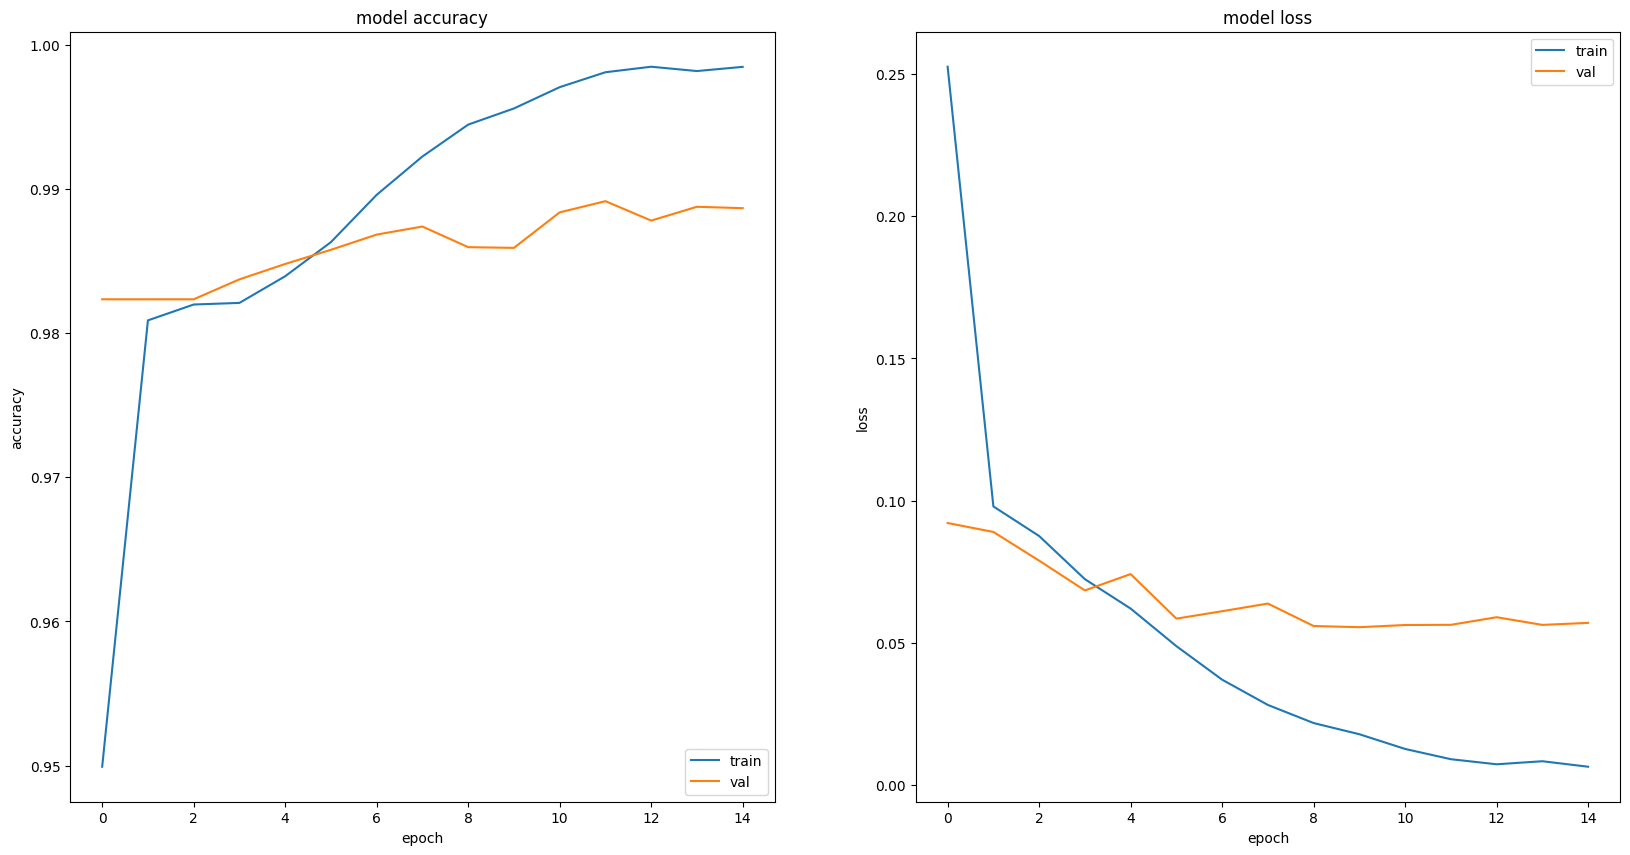

In [ ]:
s, (at, al) = plt.subplots(1,2)
s.set_figwidth(20)
s.set_figheight(10)
at.plot(history.history['accuracy'])
at.plot(history.history['val_accuracy'])
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['train', 'val'], loc='lower right')

al.plot(history.history['loss'])
al.plot(history.history['val_loss'])
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper right')

In [ ]:
model.evaluate(ds_test_encoded)

32/32 [==============================] - 8s 243ms/step - loss: 0.0592 - accuracy: 0.9861


[0.059195566922426224, 0.9860932230949402]

In [ ]:
label_pred = np.argmax(model.predict(ds_test_encoded)['logits'], axis=-1)

32/32 [==============================] - 12s 244ms/step


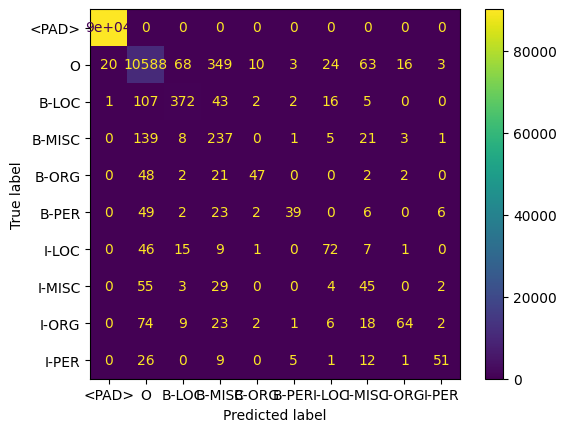

In [ ]:
CM = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(label_test.flatten(), label_pred.flatten()), display_labels=labels)
CM.plot()
plt.show()

In [ ]:
print(classification_report(label_test.flatten(), label_pred.flatten()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     90166
           1       0.95      0.95      0.95     11144
           2       0.78      0.68      0.72       548
           3       0.32      0.57      0.41       415
           4       0.73      0.39      0.51       122
           5       0.76      0.31      0.44       127
           6       0.56      0.48      0.52       151
           7       0.25      0.33      0.28       138
           8       0.74      0.32      0.45       199
           9       0.78      0.49      0.60       105

    accuracy                           0.99    103115
   macro avg       0.69      0.55      0.59    103115
weighted avg       0.99      0.99      0.99    103115



In [ ]:
import io
from tqdm import tqdm

embedding_weights = model.bert.embeddings.weights[0]

reverse_word_index = tokenizer.index_word

# Open writeable files
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

vocab_size = vocab_size

meta_lines = [reverse_word_index[word_num] + "\n" for word_num in range(1, vocab_size)]
vec_lines = ['\t'.join(embedding_weights[word_num].numpy().astype('str')) + "\n" for word_num in range(1, vocab_size)]

# Write all lines to the files in one go
out_m.writelines(meta_lines)
out_v.writelines(vec_lines)

# Close the files
out_v.close()
out_m.close()

In [ ]:
model.save_pretrained("/content/NER_Darija_BERT_mode")

--------------------------------------------
--------------------------------------------

In [ ]:
darija_text  = "\u0646\u0647\u0627\u0631 \u0627\u0644\u0623\u062D\u062F \u0627\u0644\u0641\u0627\u064A\u062A, \u0643\u0627\u0646\u062A \u0647\u0646\u0627\u0643 \u0645\u0628\u0627\u0631\u0627\u0629 \u0643\u0628\u064A\u0631\u0629 \u0641\u0627\u0644\u062F\u0627\u0631 \u0627\u0644\u0628\u064A\u0636\u0627\u0621 \u0628\u064A\u0646 \u0627\u0644\u0648\u062F\u0627\u062F \u0648 \u0627\u0644\u0631\u062C\u0627\u0621. \u0627\u0644\u062C\u0645\u0647\u0648\u0631 \u0643\u0627\u0646 \u0643\u062B\u064A\u0631 \u0648\u0627\u0644\u0623\u062C\u0648\u0627\u0621 \u062D\u0645\u0627\u0633\u064A\u0629. \u0642\u0628\u0644 \u0627\u0644\u0645\u0628\u0627\u0631\u0627\u0629\u060C \u0633\u064A\u0645\u0648 \u0648 \u0644\u064A\u0644\u0649 \u0642\u0631\u0631\u0648\u0627 \u064A\u0645\u0634\u064A\u0648 \u0644\u0645\u0637\u0639\u0645 \u0634\u0647\u064A\u0631 \u0642\u0631\u064A\u0628 \u0645\u0646 \u0645\u062D\u0637\u0629 \u0627\u0644\u0642\u0637\u0627\u0631 \u0643\u0627\u0632\u0627 \u0641\u0648\u064A\u0627\u062C\u0648\u0631\u0632. \u0648\u0627\u062D\u062F \u0627\u0644\u0635\u062D\u0641\u064A \u0645\u0646 \u062C\u0631\u064A\u062F\u0629 \u0647\u0633\u0628\u0631\u064A\u0633 \u062C\u0627 \u064A\u063A\u0637\u064A \u0627\u0644\u062D\u062F\u062B \u0648 \u0643\u062A\u0628 \u0639\u0644\u0649 \u0627\u0644\u0631\u0648\u062D \u0627\u0644\u0631\u064A\u0627\u0636\u064A\u0629 \u0628\u064A\u0646 \u0627\u0644\u062C\u0645\u0627\u0647\u064A\u0631. \u0627\u0644\u0645\u0628\u0627\u0631\u0627\u0629 \u062E\u062A\u0645\u0627\u062A \u0628\u0627\u0644\u062A\u0639\u0627\u062F\u0644 \u0648\u0627\u0644\u0643\u0644 \u0631\u062C\u0639 \u0644\u062F\u0627\u0631\u0648 \u0645\u0628\u0633\u0648\u0637" #@param {type:"string"}
darija_sentences = darija_text.split('.')
darija_sentences = [darija_sentence.split() for darija_sentence in darija_sentences]
X_darija = tokenizer.texts_to_sequences(darija_sentences)
X_darija = tf.keras.preprocessing.sequence.pad_sequences(X_darija, maxlen=max_length, padding='post', truncating='post')

pred = np.argmax(model(X_darija)['logits'], axis=-1)

index2label = {v: k for k, v in label_mapping.items()}

final_labels = {}
for i, sentence in enumerate(darija_sentences):
  for j, token in enumerate(sentence):
    final_labels[token] = index2label[pred[i][j]]

nlp = spacy.blank("ar")
doc = Doc(nlp.vocab, words=list(final_labels.keys()), ents=list(final_labels.values()))
displacy.render(doc, style="ent", jupyter=True, )